In [1]:
!pip install pandas scikit-learn seaborn

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from scipy.stats.contingency import association
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.colors as mcolors
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [3]:
# Impose a seed for reproducibility
random_seed = 421

# Dataset description

### Dataset source

The dataset has been obtained from Kaggle *Mushroom Classification* dataset [1] (licensed under CC0: Public Domain).

[1] [https://www.kaggle.com/datasets/uciml/mushroom-classification](https://www.kaggle.com/datasets/uciml/mushroom-classification)

### Dataset content

The purpose of the dataset is to determine whether a mushroom is either *edible* or *poisonous* using classification approaches. The dataset contains **8124 samples**, each sample is labelled as being either **edible or poisonous**, and contains **22 categorical features** that characterize, e.g., its smell, shape, and color.

In [12]:
# Load the dataset (the original CSV file is available from Kaggle)
csv_filename = 'mushrooms.csv'
df = pd.read_csv(csv_filename)
df.shape

(8124, 23)

In [13]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [14]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


### Minor cleaning of the dataset

Here we perform minor preliminary actions to make the dataset easier and more meaningful to work with.

In [15]:
# Require that all columns to be displayed on screen
pd.options.display.max_columns = df.shape[1]

In [17]:
# Use more explicit names for the categorical features
df['class'] = df['class'].replace({'e': 'edible', 'p': 'poisonous'})
df['cap-shape'] = df['cap-shape'].replace({'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'})
df['cap-surface'] = df['cap-surface'].replace({'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'})
df['cap-color'] = df['cap-color'].replace({'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'})
df['bruises'] = df['bruises'].replace({'t': 'Yes', 'f': 'No'})
df['odor'] = df['odor'].replace({'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'})
df['gill-attachment'] = df['gill-attachment'].replace({'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'})
df['gill-spacing'] = df['gill-spacing'].replace({'c': 'close', 'w': 'crowded', 'd': 'distant'})
df['gill-size'] = df['gill-size'].replace({'b': 'broad', 'n': 'narrow'})
df['gill-color'] = df['gill-color'].replace({'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'})
df['stalk-shape'] = df['stalk-shape'].replace({'e': 'enlarging', 't': 'tapering'})
df['stalk-root'] = df['stalk-root'].replace({'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'})
df['stalk-surface-above-ring'] = df['stalk-surface-above-ring'].replace({'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'})
df['stalk-surface-below-ring'] = df['stalk-surface-below-ring'].replace({'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'})
df['stalk-color-above-ring'] = df['stalk-color-above-ring'].replace({'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'})
df['stalk-color-below-ring'] = df['stalk-color-below-ring'].replace({'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'})
df['veil-type'] = df['veil-type'].replace({'p': 'partial', 'u': 'universal'})
df['veil-color'] = df['veil-color'].replace({'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'})
df['ring-number'] = df['ring-number'].replace({'n': 'none', 'o': 'one', 't': 'two'})
df['ring-type'] = df['ring-type'].replace({'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'})
df['spore-print-color'] = df['spore-print-color'].replace({'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'})
df['population'] = df['population'].replace({'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'})
df['habitat'] = df['habitat'].replace({'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'})
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,Yes,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,Yes,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,Yes,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,Yes,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,No,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


In [18]:
# Detect whether some features have only a single value
print(df.nunique()==1)

class                       False
cap-shape                   False
cap-surface                 False
cap-color                   False
bruises                     False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-root                  False
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                    True
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
dtype: bool


&#x1F4A1; *We observe that the feature `veil-type` is only described by a single value (namely, `partial`). We should therefore drop this feature from the dataframe because it does not contribute to the classification task.*

In [19]:
# Drop features having only a single value, because such feature are irrelevant for the classification task
df = df.drop(['veil-type'], axis=1)

# Main objective of the analysis

# Dataset exploration

Here we take further actions to examine the dataset in more details, and we apply some modifications to facilitate the main objective of the analysis.

### Useful functions

In [20]:
# Define a function to compute the crosstab, the Chi-squared, and the Crammer's V index
def get_crosstab_chisquared_crammerv(data_1, data_2):
    crosstab = pd.crosstab(data_1, data_2)
    chi_squared = chi2_contingency(crosstab)[0]    
    cramer_v = np.sqrt((chi_squared / crosstab.sum().sum()) / (min(crosstab.shape) - 1))
    return crosstab, chi_squared, cramer_v

### Detection of features values that should be regrouped

&#x1F4A1; Here we screen the dataset to identify whether some features values are systematically allocated to describe only the same target.

**Example, considering the feature `veil-color`:**

* There are four distinct values: `brown`, `orange`, `white`, `yellow`.
* The value `white` is allocated to describe samples from both `edible` and `poisonous` classes, it is therefore a relevant value.
* The value `yellow` is only allocated to describe samples from the `edible` class, it is therefore a relevant value.
* The values `brown` and `orange` are only allocated to describe samples from the `poisonous` class. We should therefore create a new value called `brown_orange`, regrouping all instances from `brown` and `orange`.

In [23]:
# Identify features having at least one zero-value for either the 'edible' or 'poisonous' class
for index in range(df.shape[1] -1):
    crosstab, _, _ = get_crosstab_chisquared_crammerv(df.iloc[:, 0], df.iloc[:, index +1])
    print(crosstab.eq(0))

# Regroup features that have at least two zero-values for either the 'edible' or 'poisonous' class
df['cap-color'] = df['cap-color'].replace(['green', 'purple'], 'green_purple')
df['odor'] = df['odor'].replace(['almond', 'anise'], 'almond_anise')
df['odor'] = df['odor'].replace(['creosote', 'fishy', 'foul', 'musty', 'pungent', 'spicy'], 'foul_et_al')
df['gill-color'] = df['gill-color'].replace(['buff', 'green'], 'buff_green')
df['gill-color'] = df['gill-color'].replace(['red', 'orange'], 'red_orange')
df['stalk-color-above-ring'] = df['stalk-color-above-ring'].replace(['buff', 'cinnamon', 'yellow'], 'buff_cinnamon_yellow')
df['stalk-color-above-ring'] = df['stalk-color-above-ring'].replace(['gray', 'orange', 'red'], 'gray_orange_red')
df['stalk-color-below-ring'] = df['stalk-color-below-ring'].replace(['buff', 'cinnamon', 'yellow'], 'buff_cinnamon_yellow')
df['stalk-color-below-ring'] = df['stalk-color-below-ring'].replace(['gray', 'orange', 'red'], 'gray_orange_red')
df['veil-color'] = df['veil-color'].replace(['brown', 'orange'], 'brown_orange')
df['ring-type'] = df['ring-type'].replace(['large', 'none'], 'large_none')
df['spore-print-color'] = df['spore-print-color'].replace(['buff', 'orange', 'purple', 'yellow'], 'buff_orange_purple_yellow')
df['population'] = df['population'].replace(['abundant', 'numerous'], 'abundant_numerous')

# Verify that no feature has more than one zero-value for either the 'edible' or 'poisonous' class
for index in range(df.shape[1] -1):
    crosstab, _, _ = get_crosstab_chisquared_crammerv(df.iloc[:, 0], df.iloc[:, index +1])
    print(crosstab.eq(0).sum(axis=1)>1)

cap-shape   bell  conical  convex   flat  knobbed  sunken
class                                                    
edible     False     True   False  False    False   False
poisonous  False    False   False  False    False    True
cap-surface  fibrous  grooves  scaly  smooth
class                                       
edible         False     True  False   False
poisonous      False    False  False   False
cap-color  brown   buff  cinnamon   gray  green_purple   pink    red  white  \
class                                                                         
edible     False  False     False  False         False  False  False  False   
poisonous  False  False     False  False          True  False  False  False   

cap-color  yellow  
class              
edible      False  
poisonous   False  
bruises       No    Yes
class                  
edible     False  False
poisonous  False  False
odor       almond_anise  foul_et_al   none
class                                     
edible   

### Selection of the most relevant features

&#x1F4A1; Here we quantify the association between each feature and the ground-truth class (`edible` or `poisonous`). Because features are categorical, we use the Cramér's V index, which returns a value of `0` if the two compared set of values show a purely random association, and a value of `1` if the two compared set of values are purely associated. We retain all features with an index superior to `0.5` and we therefore select the eight following features:
* `odor`
* `spore-print-color`
* `gill-color`
* `ring-type`
* `stalk-surface-above-ring`
* `stalk-surface-below-ring`
* `stalk-color-above-ring`
* `stalk-color-below-ring`

In [26]:
# Calculate the Cramer's V index for each feature against the target, and sort by decreasing value
cramer_v = np.zeros(df.shape[1] -1)
for index in range(df.shape[1] -1):
    _, _, cramer_v[index] = get_crosstab_chisquared_crammerv(df.iloc[:, 0], df.iloc[:, index +1])
descending_indices = np.flip(np.argsort(cramer_v))

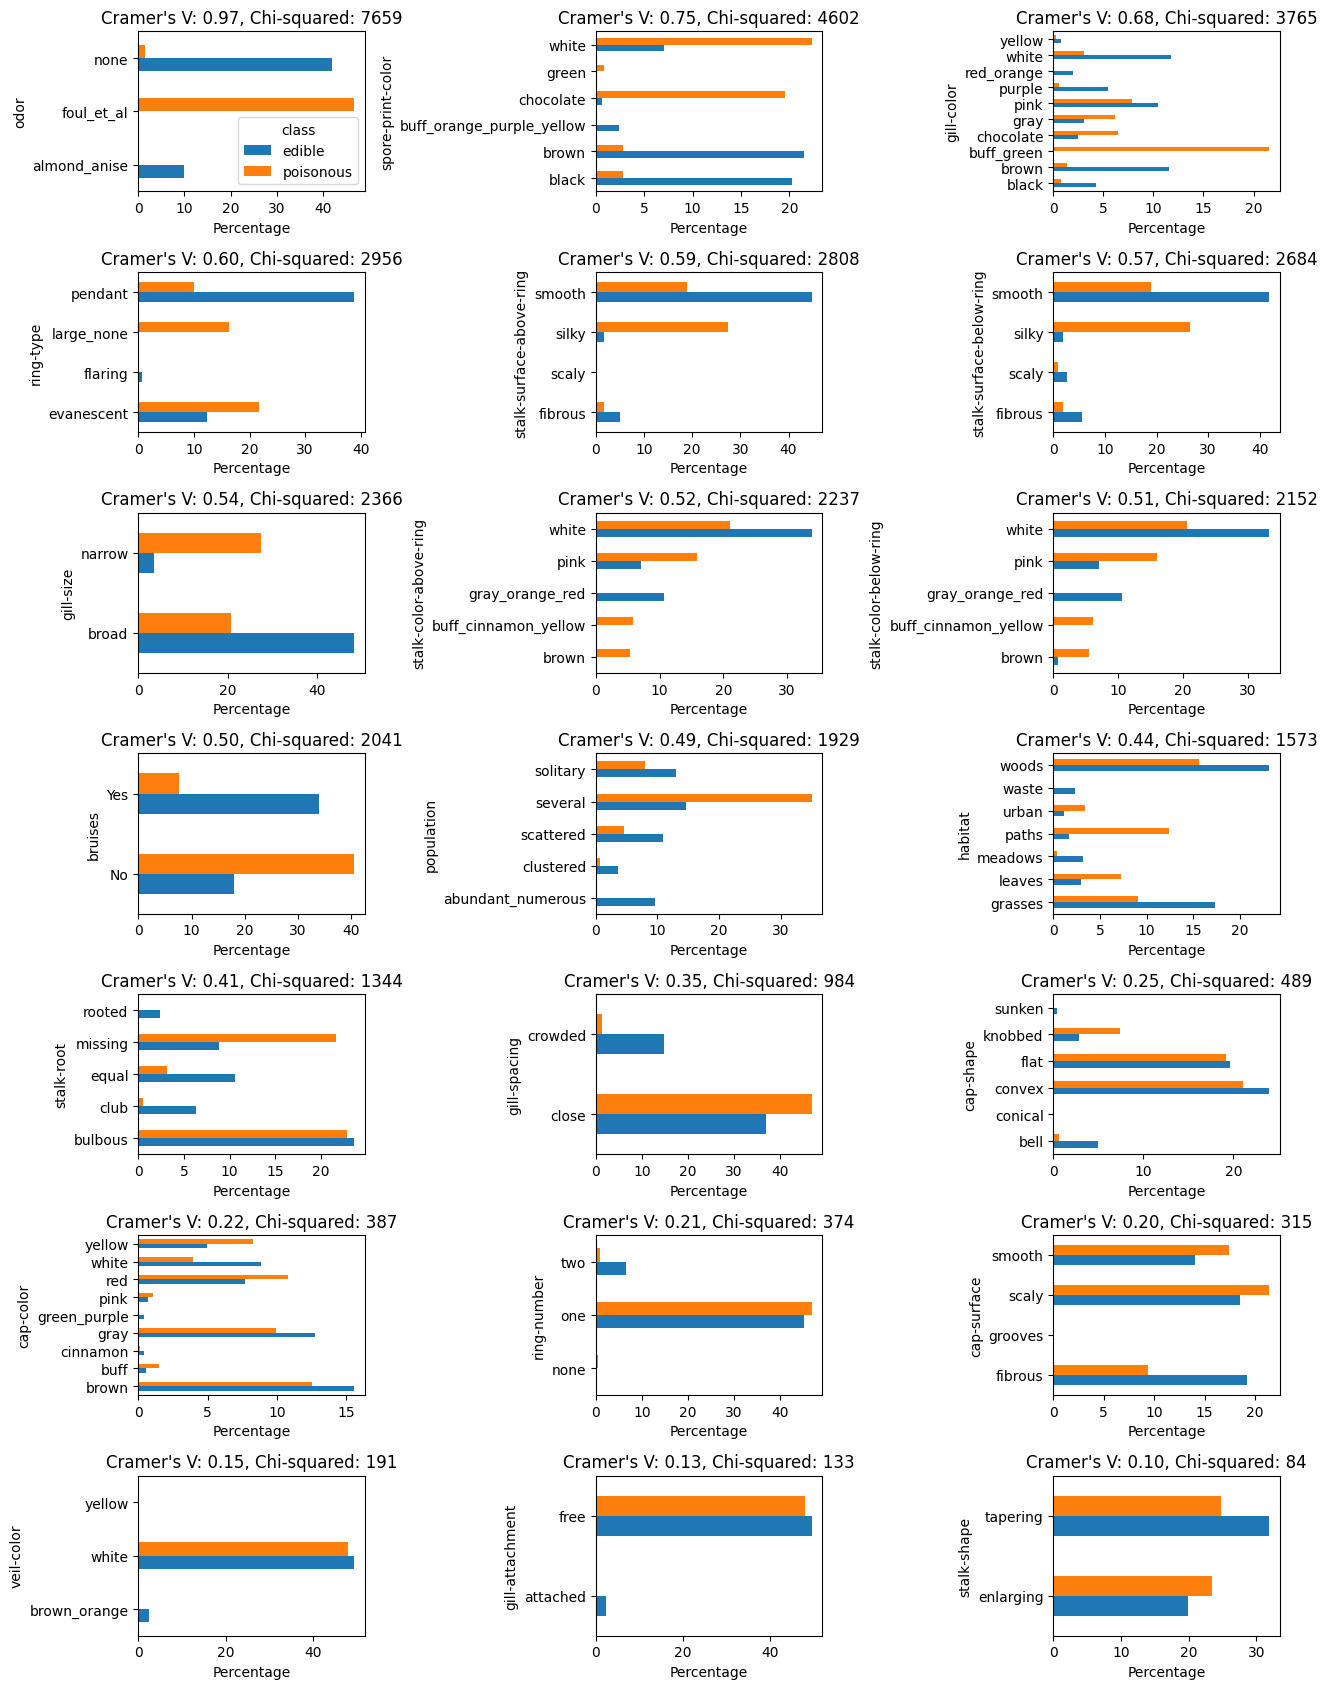

In [80]:
# Plot the crosstab of each feature, sorted by descending Cramer's V index
fig, axs = plt.subplots(7, 3, figsize=(13, 17), tight_layout=True)
axs = axs.ravel()
for index in range(21):
    descending_index = descending_indices[index] +1
    crosstab, chi_squared, cramer_v = get_crosstab_chisquared_crammerv(df.iloc[:, 0], df.iloc[:, descending_index])
    barplot = (100*crosstab/df.shape[0]).T.plot.barh(ax=axs[index], legend=index==0)
    axs[index].set_xlabel('Percentage')
    axs[index].set_title('Cramer\'s V: {:.2f}, Chi-squared: {}'.format(cramer_v, int(chi_squared)))

In [46]:
# Selection of the most relevant features, that is, Cramer's index superior to 0.5
df2 = pd.DataFrame()
df2['class'] = df['class']
df2['odor'] = df['odor']
df2['spore-print-color'] = df['spore-print-color']
df2['gill-color'] = df['gill-color']
df2['ring-type'] = df['ring-type']
df2['stalk-surface-above-ring'] = df['stalk-surface-above-ring']
df2['stalk-surface-below-ring'] = df['stalk-surface-below-ring']
df2['stalk-color-above-ring'] = df['stalk-color-above-ring']
df2['stalk-color-below-ring'] = df['stalk-color-below-ring']

### Verification that the selected features are not too strongly associated with each others

&#x1F4A1; Here we verify that the features that we have selected are not too strongly associated with each others.

[Text(0, 0, 'class'),
 Text(0, 1, 'odor'),
 Text(0, 2, 'spore-print-color'),
 Text(0, 3, 'gill-color'),
 Text(0, 4, 'ring-type'),
 Text(0, 5, 'stalk-surface-above-ring'),
 Text(0, 6, 'stalk-surface-below-ring'),
 Text(0, 7, 'stalk-color-above-ring'),
 Text(0, 8, 'stalk-color-below-ring')]

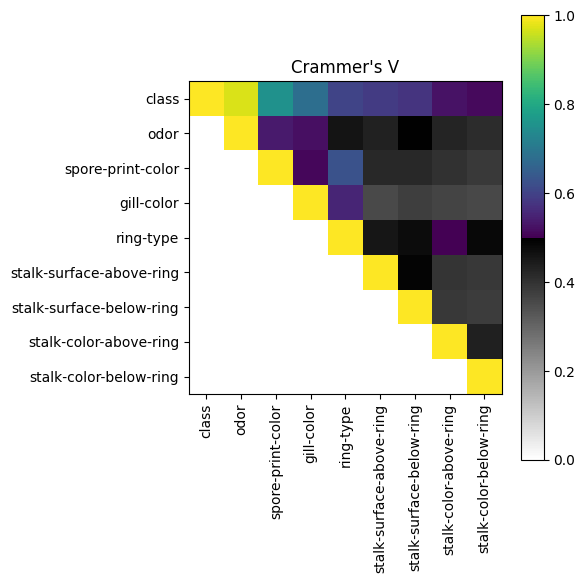

In [82]:
# Verify how selected features are correlated with each others
cramer_v = np.zeros((df2.shape[1], df2.shape[1]))

for index_a in range(df2.shape[1]):
    for index_b in range(index_a, df2.shape[1]):
        _, _, cramer_v[index_a, index_b] = get_crosstab_chisquared_crammerv(df2.iloc[:, index_a], df2.iloc[:, index_b])

colors_1 = plt.cm.binary(np.linspace(0, 1, 128))
colors_2 = plt.cm.viridis(np.linspace(0, 1, 128))
colors = np.vstack((colors_1, colors_2))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
plt.imshow(cramer_v, cmap=cmap)
plt.colorbar()
plt.title('Crammer\'s V')
ax.set_xticks(np.arange(df2.shape[1]))
ax.set_yticks(np.arange(df2.shape[1]))
ax.set_xticklabels(df2.keys(), rotation='vertical')
ax.set_yticklabels(df2.keys())

In [48]:
def evaluate_metrics(y_reference, y_predicted):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_reference, y_predicted)
    metrics['precision'], metrics['recall'], metrics['f1score'], _ = precision_recall_fscore_support(y_reference, y_predicted, average='binary')
    return metrics

In [49]:
# Prepare train and test datasets
X = df2.drop('class', axis=1)
y = df2['class'].copy()

ohe = OneHotEncoder(drop='first')
le = LabelEncoder()
clf = SVC()

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=random_seed)

X_train = ohe.fit_transform(X_train)
y_train = le.fit_transform(y_train)

X_test = ohe.transform(X_test)
y_test = le.transform(y_test)

In [51]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

params_grid = {
    'C': [1, 10, 50],
    'kernel': ['poly', 'rbf', 'sigmoid']
}

model = SVC()

# Define a GridSearchCV to search the best parameters
grid_search = GridSearchCV(
    estimator=model, param_grid=params_grid, scoring='f1', cv=skf, verbose=1)

# Search the best parameters with training data
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'C': 1, 'kernel': 'poly'}


In [54]:
model = SVC(C=1, kernel='poly')
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
metrics_array = evaluate_metrics(y_test, y_predicted)
print(metrics_array)

{'accuracy': 0.9987694831829368, 'precision': 1.0, 'recall': 0.9974468085106383, 'f1score': 0.9987217724755006}


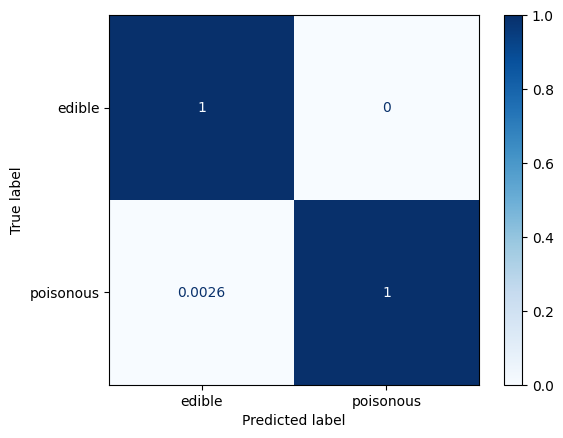

In [55]:
disp = ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=le.classes_,
    cmap=plt.cm.Blues,
    normalize='true',
)
plt.show()